In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### EDA

In [6]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-09-17 10:25:48--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv'

     0K .......... .......... .......... .......... ..........  3% 2.47M 1s
    50K .......... .......... .......... .......... ..........  7% 6.93M 0s
   100K .......... .......... .......... .......... .......... 10% 4.66M 0s
   150K .......... .......... .......... .......... .......... 14% 4.39M 0s
   200K .......... .......... .......... .......... .......... 17% 5.19M 0s
   250K .......... .......... .......... .......... .......... 21% 4.16M 0s
   300K .......... .......... .......... .......... .......... 25% 6.97M 0s
   350K .......... .......... ..

In [291]:
house_data = pd.read_csv('housing.csv')

In [292]:
house_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

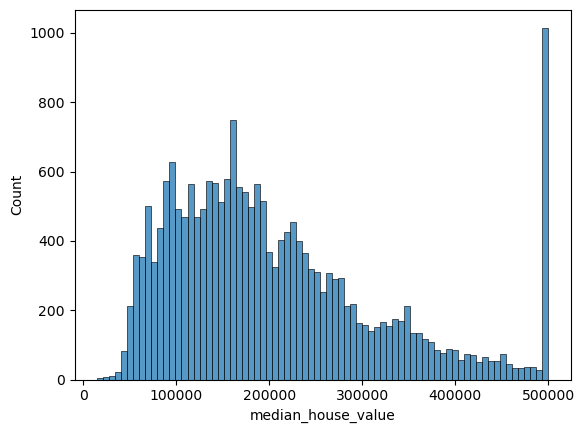

In [293]:
sns.histplot(house_data.median_house_value, bins = 75)

#### Features

In [294]:
houses = house_data[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']]
# houses = house_data.drop('ocean_proximity', axis=1)

#### Question 1

In [295]:
houses.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

#### Question 2

In [296]:
houses.population.median()

1166.0

#### Spit the data

In [337]:
n = houses.shape[0]

In [338]:
indx = np.arange(n)
np.random.seed(42)
np.random.shuffle(indx)

In [339]:
n_val = int(n * 0.20)
n_test = int(n * 0.20)
n_train = n - n_val - n_test

In [340]:
df_train = houses.iloc[indx[:n_train]]
df_val = houses.iloc[indx[n_train:n_train + n_val]]
df_test = houses.iloc[indx[n_train + n_val:]]

In [341]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [342]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [343]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

#### Question 3

In [344]:
def train_lin_reg(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [345]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    rmse = np.sqrt(mse)
    return round(rmse, 2)
    # return rmse

In [346]:
def prepare_X(df, missing):
    df = df.copy()
    df = df.fillna(missing)
    X = df.values 
    return X 

In [347]:
mean_value = df_train['total_bedrooms'].mean()

In [348]:
X_train = prepare_X(df_train, missing = 0)
w0, w = train_lin_reg(X_train, y_train)

X_val = prepare_X(df_val, missing = 0)
y_pred = w0 + X_val.dot(w)  

rmse(y_val, y_pred)

0.33

In [349]:
X_train = prepare_X(df_train, missing = mean_value)
w0, w = train_lin_reg(X_train, y_train)

X_val = prepare_X(df_val, missing = mean_value)
y_pred = w0 + X_val.dot(w)  

rmse(y_val, y_pred)

0.33

#### Question 4

In [350]:
def train_lin_reg_r(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [351]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    
    X_train = prepare_X(df_train, missing = 0)
    w0, w = train_lin_reg_r(X_train, y_train, r=r)
    
    X_val = prepare_X(df_val, missing = 0)
    y_pred = w0 + X_val.dot(w)  
   
    score = rmse(y_val, y_pred)
    
    print(r, score)

0 0.33
1e-06 0.33
0.0001 0.33
0.001 0.33
0.01 0.33
0.1 0.33
1 0.33
5 0.34
10 0.34


#### Question 5

In [352]:
def split(df, s, val_perc, test_perc, target):
    
    n = df.shape[0]
    
    indx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(indx)
    
    n_val = int(n * val_perc)
    n_test = int(n * test_perc)
    n_train = n - n_val - n_test
    
    df_train = df.iloc[indx[:n_train]]
    df_val = df.iloc[indx[n_train:n_train + n_val]]
    df_test = df.iloc[indx[n_train + n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = np.log1p(df_train[target].values)
    y_val = np.log1p(df_val[target].values)
    y_test = np.log1p(df_test[target].values)
    
    del df_train[target]
    del df_val[target]
    del df_test[target]
    
    return df_train, df_val, df_test, y_train, y_val, y_test

In [353]:
s = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

scores = []

for s in s:
    
    df_train, df_val, df_test, y_train, y_val, y_test = split(houses, s, val_perc=0.20, test_perc=0.20, target='median_house_value')    
    
    X_train = prepare_X(df_train, missing = 0)
    w0, w = train_lin_reg(X_train, y_train)

    X_val = prepare_X(df_val, missing = 0)
    y_pred = w0 + X_val.dot(w)  

    score = rmse(y_val, y_pred)
    
    scores.append(score)

In [354]:
scores

[0.34, 0.34, 0.33, 0.34, 0.34, 0.34, 0.35, 0.34, 0.35, 0.34]

In [355]:
round(np.std(scores),3)

0.005

#### Question 6

In [356]:
df_train, df_val, df_test, y_train, y_val, y_test = split(houses, s=9, val_perc=0.20, test_perc=0.20, target='median_house_value')    

In [357]:
df_full_train = pd.concat([df_train, df_val])

In [358]:
df_full_train = df_full_train.reset_index(drop=True)

In [359]:
X_full_train = prepare_X(df_full_train, missing=0)

In [360]:
y_full_train = np.concatenate([y_train, y_val])

In [361]:
w0, w = train_lin_reg_r(X_full_train, y_full_train, r=0.001)

In [362]:
X_test = prepare_X(df_test, missing=0)

In [363]:
y_pred = w0 + X_test.dot(w)   
score = rmse(y_test, y_pred)    
round(score, 2)

0.35